# OpenFOAM TemporalProbe Analysis

This program shows the evolution of multiple temporal probes for an OpenFOAM case.
    
    @author Daniel Duke <daniel.duke@monash.edu>
    @copyright (c) 2020 LTRAC
    @license GPL-3.0+
    @version 0.0.1
    @date 30/05/2021
        __   ____________    ___    ______
       / /  /_  ____ __  \  /   |  / ____/
      / /    / /   / /_/ / / /| | / /
     / /___ / /   / _, _/ / ___ |/ /_________
    /_____//_/   /_/ |__\/_/  |_|\__________/

    Laboratory for Turbulence Research in Aerospace & Combustion (LTRAC)
    Monash University, Australia


In [1]:
# Load modules
import numpy as np
import glob, copy
import tqdm
import matplotlib.pyplot as plt
%matplotlib notebook

In [28]:
case_dir = '/mnt/internal/2021_pmdi/les_pmdimv2_0.33x1.2_ures_134a_smi'
variables = ['y'] #['alphaFrac','p','rho','U','y']
t_startAveraging = 0.4
MIN_COV=1.

In [3]:
# Calculate running average in each column of A (excepting 1st column which is time.)
def running_mean(A):
    B = np.zeros_like(A)
    B[:,0] = A[:,0]
    np.cumsum(A[:,1:],axis=0,out=B[:,1:])
    count = np.arange(B.shape[0])+1
    for col in range(1,B.shape[1]):
        B[:,col] /= count
    return B


In [4]:
def makeCoordLabel(i,n,prec=2):
    label = '('
    if prec==1:
        label += ', '.join([ '%.1f' % (xyz*1e3) for xyz in (C[i][:,n-1]) ])
    elif prec==2:
        label += ', '.join([ '%.2f' % (xyz*1e3) for xyz in (C[i][:,n-1]) ])
    elif prec==3:
        label += ', '.join([ '%.3f' % (xyz*1e3) for xyz in (C[i][:,n-1]) ])
    else:
        label += ', '.join([ '%f' % (xyz*1e3) for xyz in (C[i][:,n-1]) ])
    label += ') mm'
    return label

In [5]:
def load_variable(v):
    
    # Get all the data
    files = glob.glob(case_dir+'/temporalProbes/*/'+v)
    
    # Get the time steps
    t0s = [ float(f[len(case_dir)+1:].split('/')[1]) for f in files ]
    
    if len(t0s) == 0:
        raise RuntimeError("No data available for variable `%s'" % v)
    
    # Put them in order
    idx = np.argsort(t0s)

    # Read in the data, in order of the starting time of each subset of data.
    data = []
    for i in tqdm.tqdm(idx): #range(len(idx)):
        if v=='U':
            # Read vector, convert to magnitude
            if i==0: print("Converting velocity vector to magnitude only")
            with open(files[i],'r') as File:
                d = []
                while True:
                    l=File.readline()
                    if len(l)>0:
                        if l[0] != '#':
                            r = []
                            vecSplit = l.strip().split('(')
                            r.append(float(vecSplit[0]))
                            for j in range(1,len(vecSplit)):
                                values = [float(v) for v in vecSplit[j].replace(')','').split()]
                                r.append( np.sqrt(np.sum(np.array(values)**2)) ) # MAGNITUDE OF VECTOR
                            d.append(np.array(r))
                    else: break
                        
            data.append(np.vstack(d))
        else:
            # Read scalar
            data.append( np.genfromtxt(files[i]) )
       
    # Arrange the data into a single large matrix, truncating any repeated timesteps at the end of a run
    A = None
    tmax_last = 0.
    for d in data:
        
        t = d[:,0] # time [s]
        #print(d.shape,t.min(),t.max())
        
        if A is None: # copy
            A = d[...] 
        
        elif t.min() >= tmax_last: # no overlap
            A = np.vstack((A, d))
            
        else: # has overlap - discard end of previous run
            deltat = np.abs(A[:,0] - t.min())
            te = np.where( deltat == np.nanmin(deltat) )[0][0]
            A = np.vstack((A[:te-1], d))
            #print("\tTruncate %i rows" % (A.shape[0]-te))
            
        tmax_last = t.max()
        
    del data
        
        
    # Finally, get the co-ordinate positions of each column of data by reading the header.
    with open(files[i],'r') as File:
        header=[]
        for n in range(3):
            header.append(File.readline())
    coords=np.array([ [ float(s) for s in h.strip().split()[2:] ] for h in header ])
    
    
    return A, coords

In [6]:
D=[] # data
C=[] # coords
for v in variables:
    print("Loading %s" % v)
    A, coords = load_variable(v)
    D.append(A)
    C.append(coords)

  0%|          | 0/13 [00:00<?, ?it/s]

Loading y


100%|██████████| 13/13 [00:27<00:00,  2.08s/it]


In [23]:
# Calculate total pressure if U rho and p are available
if 'U' in variables and 'rho' in variables and 'p' in variables:
    print("Calculating total and dynamic pressure")
    
    iU=variables.index('U')
    iR=variables.index('rho')
    iP=variables.index('p')
    q = 0.5*D[iR]*D[iU]**2
    p = D[iP]
    
    variables.append('Total pressure')
    D.append(q+p)
    D[-1][:,0] = D[iP][:,0]
    C.append(C[-1])
    
print("# vars = %i/%i/%i, # timesteps = %i" % (len(D),len(C),len(variables),A.shape[0]))

# vars = 1 1 1, # timesteps = 609513


Skipped y n=1 @ (0.00, 1.47, 0.31) mm - no significant variation, cov=0.946314
Skipped y n=2 @ (0.00, 1.37, 0.29) mm - no significant variation, cov=0.921496
Skipped y n=3 @ (0.00, 1.27, 0.27) mm - no significant variation, cov=0.910066
Skipped y n=4 @ (0.00, 1.17, 0.25) mm - no significant variation, cov=0.846693
Skipped y n=5 @ (0.00, 1.08, 0.23) mm - no significant variation, cov=0.817528
Skipped y n=6 @ (0.00, 0.98, 0.21) mm - no significant variation, cov=0.770294
Skipped y n=7 @ (0.00, 0.88, 0.19) mm - no significant variation, cov=0.749268
Skipped y n=8 @ (0.00, 0.78, 0.17) mm - no significant variation, cov=0.714244
Skipped y n=9 @ (0.00, 0.68, 0.15) mm - no significant variation, cov=0.682124
Skipped y n=10 @ (0.00, 0.59, 0.12) mm - no significant variation, cov=0.652661
Skipped y n=11 @ (0.00, 0.49, 0.10) mm - no significant variation, cov=0.626941
Skipped y n=12 @ (0.00, 0.39, 0.08) mm - no significant variation, cov=0.605164
Skipped y n=13 @ (0.00, 0.29, 0.06) mm - no signi

<IPython.core.display.Javascript object>


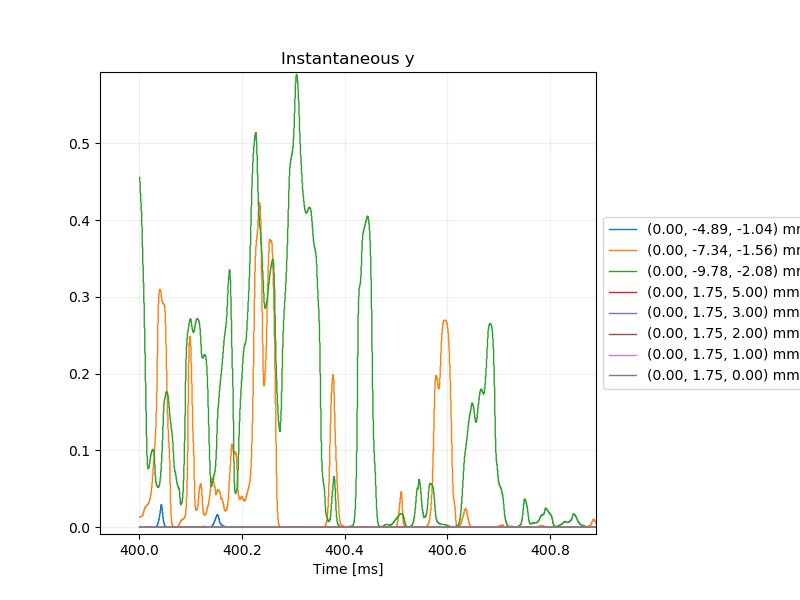

PLOTTED y n=23 @ (0.00, -4.89, -1.04) mm - cov=46.458345
PLOTTED y n=24 @ (0.00, -7.34, -1.56) mm - cov=4.220536
PLOTTED y n=25 @ (0.00, -9.78, -2.08) mm - cov=1.782862
Skipped y n=26 @ (0.00, 4.00, 11.00) mm - no significant variation, cov=0.000000
Skipped y n=27 @ (0.00, 3.50, 11.00) mm - no significant variation, cov=0.000000
Skipped y n=28 @ (0.00, 2.75, 11.00) mm - no significant variation, cov=0.000193
Skipped y n=29 @ (0.00, 1.75, 11.00) mm - no significant variation, cov=0.749827
Skipped y n=30 @ (0.00, 1.75, 9.00) mm - no significant variation, cov=0.822827
Skipped y n=31 @ (0.00, 1.75, 7.00) mm - no significant variation, cov=0.584624
PLOTTED y n=32 @ (0.00, 1.75, 5.00) mm - cov=1.235898
PLOTTED y n=33 @ (0.00, 1.75, 3.00) mm - cov=4.549076
PLOTTED y n=34 @ (0.00, 1.75, 2.00) mm - cov=1.979928
PLOTTED y n=35 @ (0.00, 1.75, 1.00) mm - cov=1.189957
PLOTTED y n=36 @ (0.00, 1.75, 0.00) mm - cov=1.347068
Skipped y n=37 @ (0.00, 1.75, -1.00) mm - no significant variation, cov=0.627

In [37]:
for i in range(len(variables)):
    A=D[i]
    v=variables[i]
    t = A[:,0]
    
    fig=None
    for n in range(1,A.shape[1]):
        # Determine coefficient of variance. Must pass threshold to be worth plotting!
        cov=np.std(A[:,n])/(1e-12+np.nanmean(A[:,n]))
        if cov>=MIN_COV:
            if fig is None:
                fig=plt.figure(figsize=(8,6))
                ax=fig.add_subplot(111)
                plt.grid(alpha=.2)
            ax.plot(t*1e3, A[:,n], lw=1, label=makeCoordLabel(i,n))
            if v=='p' or 'pressure' in v: ax.set_yscale('log')
            print("PLOTTED %s n=%i @ %s - cov=%f"%(v,n,makeCoordLabel(i,n),cov))
        else:
            print("Skipped %s n=%i @ %s - no significant variation, cov=%f"%(v,n,makeCoordLabel(i,n),cov))
            
    if fig is not None:
        plt.xlabel('Time [ms]')

        # Shrink current axis by 20%
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

        plt.title("Instantaneous "+v);
    else:
        print("Skipped "+v);

<IPython.core.display.Javascript object>


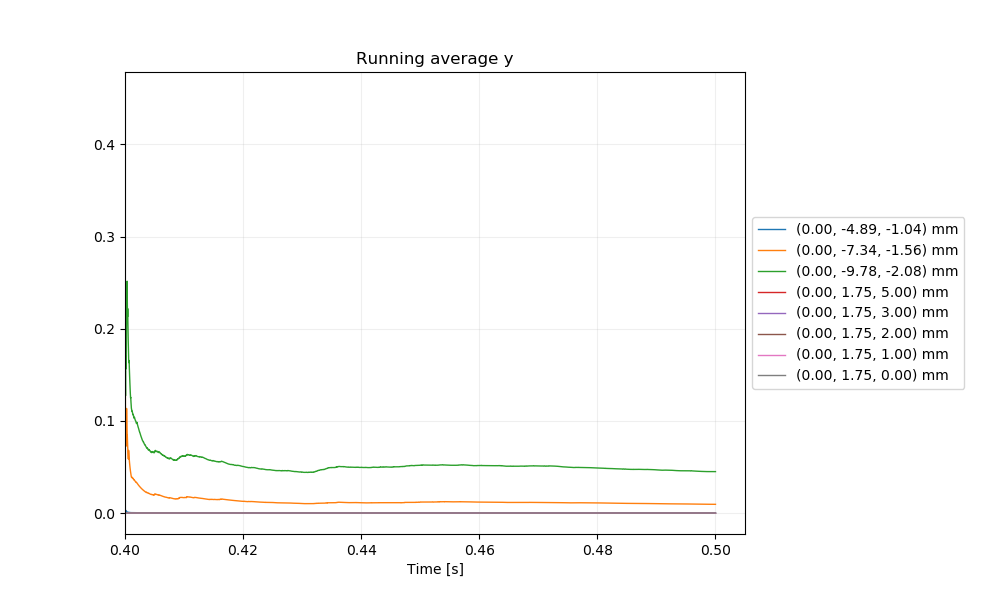

In [31]:
# RUNNING AVERAGE
for i in range(len(variables)):
    A=D[i]
    v=variables[i]
    t = A[:,0]
    
    t0 = np.where(t >= t_startAveraging )[0][0] # start averaging here.
    B = running_mean(A[t0:,...])
    
    
    fig=None
    for n in range(1,B.shape[1]):
        # Determine coefficient of variance. Must pass threshold to be worth plotting!
        cov=np.std(A[:,n])/(1e-12+np.nanmean(A[:,n]))
        if cov>=MIN_COV:
            if fig is None:
                fig=plt.figure(figsize=(10,6))
                ax=fig.add_subplot(111)
                plt.grid(alpha=.2)
            ax.plot(B[:,0], B[:,n], lw=1, label=makeCoordLabel(i,n));
        else:
            pass#print("Skipped %s n=%i @ %s - no significant variation over time"%(v,n,makeCoordLabel(i,n)))
    if fig is not None:       
        plt.xlabel('Time [s]')
        plt.xlim(t_startAveraging,)

        # Shrink current axis by 20%
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

        plt.title("Running average "+v);
    else:
        print("Skipped "+v);

SAMPLING RATE = 6.095181 MHz


<IPython.core.display.Javascript object>


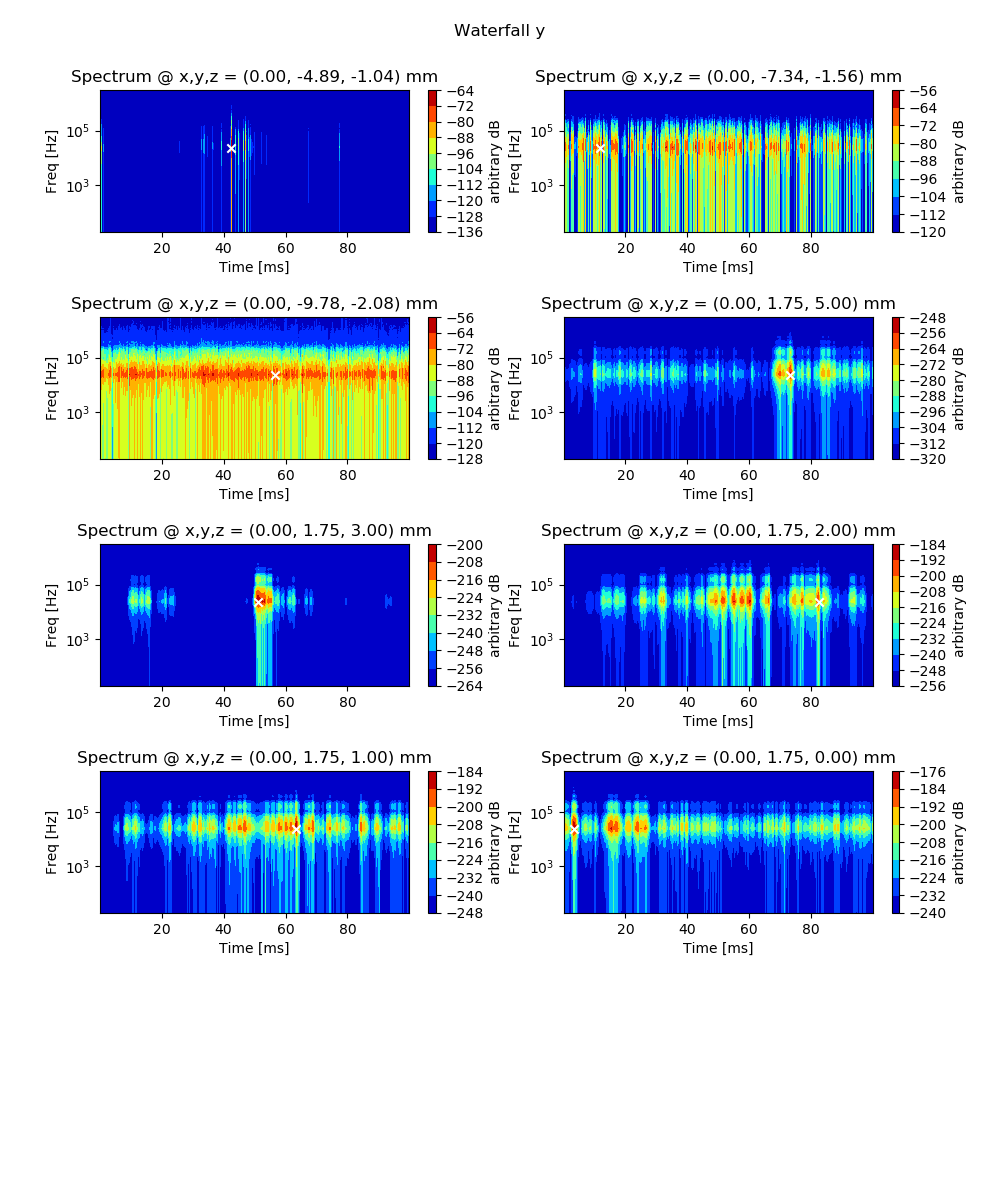

n=23 @ (0.000, -4.891, -1.040) mm: Peak spectral power -70.947 dB at f=23.8093 kHz, t=42.4676 ms
n=24 @ (0.000, -7.336, -1.559) mm: Peak spectral power -59.3976 dB at f=23.8093 kHz, t=11.6341 ms
n=25 @ (0.000, -9.781, -2.079) mm: Peak spectral power -60.3541 dB at f=23.8093 kHz, t=56.543 ms
n=32 @ (0.000, 1.750, 5.000) mm: Peak spectral power -254.069 dB at f=23.8093 kHz, t=73.3012 ms
n=33 @ (0.000, 1.750, 3.000) mm: Peak spectral power -201.987 dB at f=23.8093 kHz, t=51.1775 ms
n=34 @ (0.000, 1.750, 2.000) mm: Peak spectral power -190.704 dB at f=23.8093 kHz, t=82.4153 ms
n=35 @ (0.000, 1.750, 1.000) mm: Peak spectral power -184.282 dB at f=23.8093 kHz, t=63.4888 ms
n=36 @ (0.000, 1.750, 0.000) mm: Peak spectral power -177.074 dB at f=23.8093 kHz, t=3.29178 ms
Maximum spectral power (dB): [-59.397578050518064, '(0.000, -7.336, -1.559) mm']


In [36]:
# WATERFALL PLOT
from scipy.signal import spectrogram

for i in range(len(variables)):
    A=D[i]
    v=variables[i]
    t = A[:,0]
    dt = np.nanmean(np.diff(t))
    fig=None
    m=1
    row=5 #rows of graphs to draw - edit as required
    col=2 # columns of graphs to draw - edit as required
    maxSS=[-np.inf,'']
    if i==0: print("SAMPLING RATE = %f MHz" % (1e-6/dt))
    for n in range(1,A.shape[1]):
        # Determine coefficient of variance. Must pass threshold to be worth plotting!
        cov=np.std(A[:,n])/(1e-12+np.nanmean(A[:,n]))
        if (m<row*col):
            if (cov>=MIN_COV):
                if fig is None: fig=plt.figure(figsize=(10,12)) # plot size can be edited as required
                ax=fig.add_subplot(row,col,m)
                yf,yt,yS=spectrogram( A[:,n], fs=1.0/dt, mode='magnitude')
                SS=20*np.log10(yS+np.nanmax(yS)/1000)
                yf[yf<2.0/(len(t)*dt)]=2.0/(len(t)*dt)
                tt,ff = np.meshgrid(yt*1e3,yf)
                CH=ax.contourf(tt,ff,SS,cmap=plt.cm.jet)
                plt.colorbar(CH,label='arbitrary dB')
                plt.xlabel('Time [ms]')
                plt.ylabel('Freq [Hz]')
                plt.title('Spectrum @ x,y,z = %s' % makeCoordLabel(i,n))
                plt.ylim(ff.min(),ff.max())
                plt.yscale('log')  
                m+=1
                
                # Find maxima frequency and time
                pi=np.where(SS==np.nanmax(SS))
                pf=ff[pi]
                pt=tt[pi]
                if np.nanmax(SS) > maxSS[0]: maxSS=[np.nanmax(SS),makeCoordLabel(i,n,prec=3)]
                print("n=%i @ %s: Peak spectral power %g dB at f=%g kHz, t=%g ms" % (n,makeCoordLabel(i,n,prec=3),\
                                                                            np.nanmax(SS),pf*1e-3,pt))
                ax.scatter([pt],[pf],marker='x',c='w',zorder=10)
            else:
                pass
                #print("Skipped %s n=%i @ %s - no significant variation over time" % (v,n,makeCoordLabel(i,n)));
        else:
            print("Out of plot space")
            break
    plt.suptitle("Waterfall "+v)
    plt.subplots_adjust(top=.925,bottom=.05,left=.1,right=.95,hspace=.6,wspace=.2);
    plt.savefig("waterfall_%s.pdf" % v)
    print("Maximum spectral power (dB):",maxSS)